<a href="https://colab.research.google.com/github/fahad110011/civic-price-predictor/blob/main/notebooks/03_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ─── Cell 1: Install dependencies ───────────────────────────────────────────────
%%bash
pip install xgboost scikit-learn matplotlib


In [ ]:
# ─── Cell 2: Imports & Load Civic Data ─────────────────────────────────────────
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the filtered Civic subset from GitHub
url = (
    "https://raw.githubusercontent.com/"
    "fahad110011/civic-price-predictor/"
    "main/data/raw/civic_raw.csv"
)
df = pd.read_csv(url)

# Clean up column names of any stray whitespace
df.columns = df.columns.str.strip()

# Verify the columns
print("Columns in df:", df.columns.tolist())
df.head()


Columns in df: ['year', 'odometer', 'condition', 'transmission', 'state', 'price']


,year,odometer,condition,transmission,state,price
0,2020.0,9954.0,good,other,al,26590
1,2018.0,28942.0,good,other,al,18590
2,2018.0,7885.0,good,other,al,21590
3,1995.0,215000.0,good,manual,al,3500
4,2003.0,236890.0,excellent,automatic,al,3950


In [ ]:
# ─── Cell 3: Baseline Model (year + odometer only) ─────────────────────────────
# Features & target
X = df[['year', 'odometer']]
y = df['price']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Train a simple XGBoost regressor
baseline = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
baseline.fit(X_train, y_train)

# Evaluate
y_pred = baseline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Baseline RMSE: ${rmse:,.0f}")


Baseline RMSE: $4,964


In [ ]:
# ─── Cell 4 (corrected): Pipeline with Categorical Features & new split ─────────
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# 4.1 Define numeric & categorical feature lists
numeric_features     = ['year', 'odometer']
categorical_features = ['condition', 'transmission', 'state']

# 4.2 Reconstruct X and y to include categoricals
X = df[numeric_features + categorical_features]
y = df['price']

# 4.3 New train/test split (so X_train now has all 5 cols)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 4.4 Build the preprocessor
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

# 4.5 Full pipeline: preprocessing + XGBoost
pipeline = Pipeline([
    ('pre', preprocessor),
    ('xgb', xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    ))
])

# 4.6 Train & evaluate
pipeline.fit(X_train, y_train)
y_pred2 = pipeline.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
print(f"With categoricals RMSE: ${rmse2:,.0f}")


With categoricals RMSE: $4,408


In [ ]:
# ─── Cell 5 (corrected): Hyperparameter Tuning ─────────────────────────────────
from sklearn.model_selection import GridSearchCV

param_grid = {
    'xgb__n_estimators':  [50, 100, 200],
    'xgb__max_depth':     [3, 4, 6],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=1,
    error_score='raise'
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

best_cv_rmse = -grid.best_score_
print(f"CV RMSE (best): ${best_cv_rmse:,.0f}")

# Final test‐set evaluation
y_final = grid.best_estimator_.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_final))
print(f"Test RMSE (tuned): ${final_rmse:,.0f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}
CV RMSE (best): $4,143
Test RMSE (tuned): $4,019


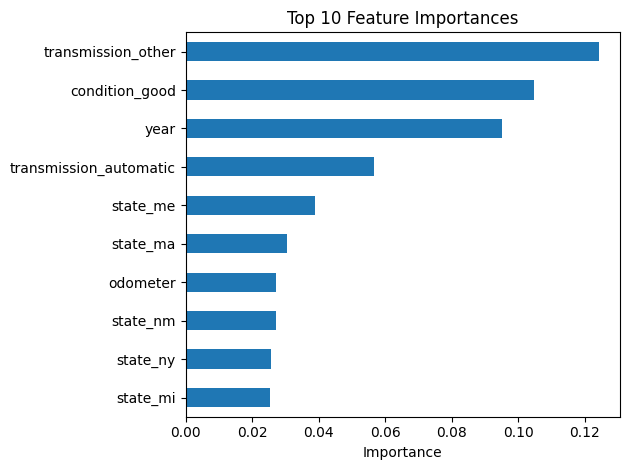

In [ ]:
# ─── Cell 6 (corrected): Feature Importance ────────────────────────────────────
import matplotlib.pyplot as plt

# Extract one‐hot encoder from the best pipeline
ohe = grid.best_estimator_.named_steps['pre'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(categorical_features)

# Combine with numeric feature names
feature_names = numeric_features + list(cat_names)

# Get importances
importances = grid.best_estimator_.named_steps['xgb'].feature_importances_
imp_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 10 features
plt.figure()
imp_df.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [44]:
import joblib, os

# ► replace “grid.best_estimator_” with whatever variable holds your final model
final_pipe = grid.best_estimator_

os.makedirs("model", exist_ok=True)
joblib.dump(final_pipe, "model/pipe.pkl", protocol=4)   # ← force older pickle format
print("✔ saved model/pipe.pkl with protocol 4")


✔ Saved model/pipe.pkl with protocol 4


In [46]:
from google.colab import files
files.download("model/pipe.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>